In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import ipywidgets as widgets
import matplotlib as mpl
import pandas as pd
import random
import itertools
from matplotlib import colors
import matplotlib.pyplot as plt

import ml_plotting_functions

mpl.rcParams['figure.dpi'] = 150 # Increase size in Jupyter

In [4]:
##################################################
# The plotting functions for the three main views
##################################################

df = pd.DataFrame()


def plot_marbles_with_truth_color(class_imbalance, n_x=10, n_y=10):
    fig, ax = plt.subplots(ncols=1, figsize=(3, 3))

    # data prep
    df['coords'] = list(itertools.product(*[range(n_x), range(n_y)]))
    df['true_values'] = [int(random.random() + class_imbalance) for _ in range(n_x * n_y)]
    df['true_colors'] = df['true_values'].apply(lambda v: ml_plotting_functions.DEFAULT_MARBLE_COLOR  if v == 1 else 'white')

    # actual plotting
    ml_plotting_functions.draw_value_circles(ax, df['true_colors'], df['coords'])

    # finalize
    fig.suptitle("How the truth looks like")
    plt.show()
    plt.close(fig)


def plot_classifier_view(quality):
    fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

    # data prep
    df['predicted_values'] = ml_plotting_functions.predict_values(df['true_values'], quality=quality)
    df['predicted_value_colors'] = df['predicted_values'].astype(str)
    df['face_colors'] = df['predicted_values'].apply(lambda c: tuple(list(colors.to_rgb(ml_plotting_functions.DEFAULT_MARBLE_COLOR)) + [c]))

    # actual plotting
    ml_plotting_functions.draw_value_circles(ax1, df['face_colors'], df['coords'])
    ml_plotting_functions.plot_predicted_values_as_swarmplot_with_color_gradient(ax2,
                                                           df.sort_values('predicted_values')['predicted_values'],  # since for the swarm plot, marker order is sorted by value
                                                           s=10)
    # finalize
    fig.suptitle("How the classifier sees it")
    plt.show()
    plt.close(fig)


def plot_evaluation_metrics(cutoff):
    fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(12, 3))

    # data prep
    df['predicted_binary_values'] = df['predicted_values'].apply(lambda x: 0 if x < cutoff else 1)
    df_sorted = df.sort_values('predicted_values')

    # actual plotting
    ml_plotting_functions.plot_predicted_values_as_swarmplot_with_green_red_outline(ax1,
                                                              df_sorted['true_values'],
                                                              df_sorted['predicted_values'],
                                                              df_sorted['predicted_binary_values'], cutoff)
    ml_plotting_functions.make_roc_curve_plot(ax2, df['true_values'], df['predicted_values'], cutoff)
    ml_plotting_functions.make_precision_recall_bar_chart(ax3, df['true_values'], df['predicted_binary_values'])

    # finalize
    fig.suptitle("Evaluation metrics with cutoff\n", va='bottom')
    plt.show()
    plt.close(fig)

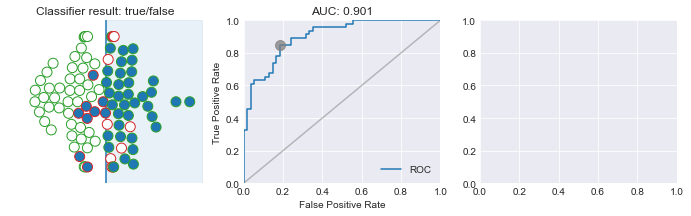

In [5]:
##################################################
# Setup widgets, interactivity & layout
##################################################

# Create the widgets
class_imbalance_widget = widgets.FloatSlider(min=0.1,
                                             max=0.9,
                                             step=0.1,
                                             value=0.5,
                                             continuous_update=False,
                                             description='Class imbalance',
                                             style={'description_width': 'initial'})

quality_widget = widgets.FloatSlider(min=0,
                                     max=1,
                                     step=0.1,
                                     value=0.5,
                                     continuous_update=False,
                                     description='Classifier strength',
                                     style={'description_width': 'initial'})

cutoff_widget = widgets.FloatSlider(min=0,
                                    max=1,
                                    step=0.05,
                                    value=0.5,
                                    continuous_update=False,
                                    description='Cutoff value',
                                    style={'description_width': 'initial'})


# Create the views
truth_view = widgets.interactive(plot_marbles_with_truth_color,
                                 class_imbalance=class_imbalance_widget,
                                 n_x=widgets.fixed(10),
                                 n_y=widgets.fixed(10))
classifier_view = widgets.interactive(plot_classifier_view, quality=quality_widget)
metrics_view = widgets.interactive(plot_evaluation_metrics, cutoff=cutoff_widget)

# In case of value change, update downstream views
class_imbalance_widget.observe(lambda x: classifier_view.update(), 'value')
class_imbalance_widget.observe(lambda x: metrics_view.update(), 'value')
quality_widget.observe(lambda x: metrics_view.update(), 'value')

# Put the views into a layout grid
grid = widgets.GridspecLayout(2, 3, layout=widgets.Layout(justify_content='center'))
grid[0, 0] = truth_view
grid[0, 1:] = classifier_view
grid[1, :] = metrics_view


In [6]:
##################################################
# Make the app
##################################################
import warnings
warnings.filterwarnings('ignore')
title_html = """
<h2>Machine Learning Model Evaluation: Visual & Interactive</h2>

<ul style="line-height: 1.5">
  <li>A classifier was trained to identify positive targets, here visualized as blue marbles (upper left).
The ratio of negative (white) and positive (blue) targets can be controlled via the slider.</li>

  <li>The strength-adjustable classifier then predicts a score from one to zero for each item (upper center and right).</li>
  
  <li>Based on this score and an adjustable cutoff threshold, each item is classified as either positive or negative.
Correct or incorrect classification is highlighted with a green or red outline for each circle (lower left). 
Subsequently, 
<a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic"> the ROC curve and the AUC value<a>
(lower center) as well as
<a href="https://en.wikipedia.org/wiki/Precision_and_recall"> precision, recall</a> 
and 
<a href="https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification"> accuracy </a> 
(lower right) can be calculated.</li>
</ul>
"""

description_html = """
<style>
p {
    margin-bottom: 1.2em;
    line-height: 1.5;
}
</style>

<p>The effects of different configurations regarding class imbalance, model strength or cutoff threshold on evaluation metrics can be studied.
Also, the relationship between these metrics, e.g. the tradeoff between precision and recall, can be observed.</p>

<p>This allows e.g. to explore the problem with accuracy for unbalanced classes: In the case of few positive targets, 
a weak classifier with a high threshold will yield a high accuracy simply due to labelling everything negative.</p>

<p>Source code <a href="https://github.com/dhaitz/machine-learning-interactive-visualization"> here</a>. Ideas, suggestions and improvements welcome! /<a href="https://dhaitz.github.io">dh</a></p>
"""
app_contents = [widgets.HTML(title_html, layout=widgets.Layout(margin='0 0 3em 0', max_width='800px')),
            grid,
            widgets.HTML(description_html, layout=widgets.Layout(margin='3em 0 0 0', max_width='800px'))]
app = widgets.VBox(app_contents, layout=widgets.Layout(max_width='1024px', margin='0 auto 0 auto'))


In [8]:
display(app)
import warnings
warnings.filterwarnings('ignore')